# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, FunctionTransformer, LabelEncoder
from sklearn.pipeline import Pipeline as skPipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin

from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

# Reading & Cleaning Data

In [2]:
# 1. Column names (15 features + label)
headers = [
    'age',
    'workclass',
    'fnlwgt',
    'education',
    'education-num',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'capital-gain',
    'capital-loss',
    'hours-per-week',
    'native-country',
    'pred'   # label (<=50K / >50K)
]

# 2. Read raw data
original_train_df = pd.read_csv(
    "census-income.data.csv",
    header=None,
    names=headers,
    index_col=False
)

original_test_df = pd.read_csv(
    "census-income.test.csv",
    header=None,
    names=headers,
    index_col=False
)

# Work on copies
train_df = original_train_df.copy()
test_df = original_test_df.copy()

In [3]:
# Transform target into binary

target_map = {
'<=50K': 0,
'>50K': 1,
'<=50K.': 0,
'>50K.': 1
}

train_df['pred'] = train_df['pred'].str.strip().map(target_map)
test_df['pred'] = test_df['pred'].str.strip().map(target_map)

In [4]:
# ---------- Helper Functions ----------

def data_to_str(df):
    """Strip leading/trailing spaces from all object columns."""
    df = df.copy()
    str_cols = df.select_dtypes(include=["object"]).columns
    for col in str_cols:
        df[col] = df[col].str.strip()
    return df

def replace_qmarks(df):
    """Convert '?' to np.nan."""
    return df.replace("?", np.nan)


def category_remapping(df):
    '''Maps categorical variables into more functional bins'''
    copy_df = df.copy()
    
    # workclass
    workclass_mapping = {
        'State-gov':'Government',
        'Local-gov':'Government',
        'Federal-gov':'Government',
        'Self-emp-inc':'Incorporated-Entrepreneur',
        'Self-emp-not-inc':'Unincorporated-Entrepreneur',
        'Without-pay':'Unemployed',
        'Never-worked':'Unemployed',
        'Private':'Private'
    }
    if "workclass" in copy_df:
        copy_df["workclass-cat"] = copy_df["workclass"].map(workclass_mapping)
    
    # education
    edu_mapping = {
        'Preschool':'HS-dropout',
        '1st-4th':'HS-dropout',
        '5th-6th':'HS-dropout',
        '7th-8th':'HS-dropout',
        '9th':'HS-dropout',
        '10th':'HS-dropout',
        '11th':'HS-dropout',
        '12th':'HS-dropout',
        'HS-grad':'HS-grad',
        'Some-college':'Some-college',
        'Assoc-acdm':'Some-college',
        'Assoc-voc':'Some-college',
        'Bachelors':'Bachelors',
        'Masters':'Advanced-degree',
        'Prof-school':'Advanced-degree',
        'Doctorate':'Advanced-degree'
    }
    if "education" in copy_df:
        copy_df["education-cat"] = copy_df["education"].map(edu_mapping)
    
    # marital-status
    marital_mapping = {
        'Never-married':'Single/Unmarried',
        'Divorced':'Single/Unmarried',
        'Separated':'Single/Unmarried',
        'Widowed':'Single/Unmarried',
        'Married-spouse-absent':'Single/Unmarried',
        'Married-civ-spouse':'Married',
        'Married-AF-spouse':'Married'
    }
    if "marital-status" in copy_df:
        copy_df["marital-cat"] = copy_df["marital-status"].map(marital_mapping)
    
    # occupation
    occupation_mapping = {
        'Exec-managerial':'White-collar',
        'Prof-specialty':'White-collar',
        'Tech-support':'White-collar',
        'Other-service':'Service',
        'Sales':'Service',
        'Adm-clerical':'Service',
        'Protective-serv':'Service',
        'Craft-repair':'Blue-collar',
        'Transport-moving':'Blue-collar',
        'Machine-op-inspct':'Blue-collar',
        'Armed-Forces':'Military',
        'Priv-house-serv':'Manual',
        'Farming-fishing':'Manual',
        'Handlers-cleaners':'Manual'
    }
    if "occupation" in copy_df:
        copy_df["occupation-cat"] = copy_df["occupation"].map(occupation_mapping)
    
    # native-country → native_imm_cat
    if "native-country" in copy_df:
        s = copy_df["native-country"]
        native_imm_cat = (
            s.map({"United-States": "Native"})  # US → Native, others NaN
             .fillna("Immigrant")              # non-US, non-missing → Immigrant
             .where(s.notna(), pd.NA)          # where original was missing, keep NA
        )
        copy_df["native_imm_cat"] = native_imm_cat.replace({pd.NA: np.nan})
    
    # hours-per-week binning
    if "hours-per-week" in copy_df:
        hrs_bins = [0, 30, 40, 60, 100]
        hrs_labels = ["Part-Time", "Underworked", "Full-Time+", "Overworked"]
        copy_df["hours_bin"] = pd.cut(copy_df["hours-per-week"], bins=hrs_bins, labels=hrs_labels)
    
    # capital-flow binning
    if "capital-gain" in copy_df and "capital-loss" in copy_df:
        copy_df["net-capital-flow"] = copy_df["capital-gain"] - copy_df["capital-loss"]
        cap_bins = [-10000, 10000, 99999]
        cap_labels = ["Standard", "High Net-Worth"]
        copy_df["cap_flow_bin"] = pd.cut(copy_df["net-capital-flow"], bins=cap_bins, labels=cap_labels)
    
    # Drop original columns we replaced
    drop_cols = [
        "workclass", "fnlwgt", "education", "education-num",
        "marital-status", "occupation", "native-country",
        "hours-per-week", "capital-gain", "capital-loss",
        "net-capital-flow"
    ]
    existing = [c for c in drop_cols if c in copy_df.columns]
    copy_df = copy_df.drop(columns=existing)
    
    return copy_df


class BasicPrep(BaseEstimator, TransformerMixin):
    """
    1) strip whitespace
    2) convert '?' → np.nan
    3) apply all category/bucket remappings & drop originals
    """
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        df = X.copy()
        df = data_to_str(df)
        df = replace_qmarks(df)
        df = category_remapping(df)
        return df


**We dropped fnlwgt as it's not a useful statistic, and we know that education-num covers the same information as education so we drop that as well.**

**Based on our analysis further in the notebook, we identify categorical divisions for our features that provide strong relationships to the target variable.**

# Exploratory Data Analysis

In [10]:
def plot_prevalence_individual(df, categories, pred_col='pred'):
    sns.set_theme(style="whitegrid")

    teal_gradient = sns.color_palette("crest", 20) 

    for cat in categories:
        plt.figure(figsize=(10, 6))

        prevalence = df.groupby(cat)[pred_col].mean().sort_values()

        colors = teal_gradient[:len(prevalence)]

        ax = prevalence.plot(
            kind='bar',
            color=colors,
            edgecolor="black"
        )

        plt.title(
            f"Target Prevalence by {cat.replace('-', ' ').title()}",
            fontsize=20,
            fontweight='bold',
            color="#0B2D2F",            
            pad=15
        )
        plt.ylabel("Proportion with target = 1", fontsize=14, color="#0B2D2F")
        plt.xlabel(cat.replace('-', ' ').title(), fontsize=14, color="#0B2D2F")

        plt.xticks(rotation=45, ha='right', fontsize=14, color="#0B2D2F")
        plt.yticks(fontsize=14, color="#0B2D2F")

        ax.grid(axis='y', linestyle='--', alpha=0.5)

        sns.despine()

        plt.tight_layout()
        plt.show()

### Visualizing Target Prevalence by Feature
**This will inform our decisions regarding remapping and binning these specified categories into broader categories with more meaning.**

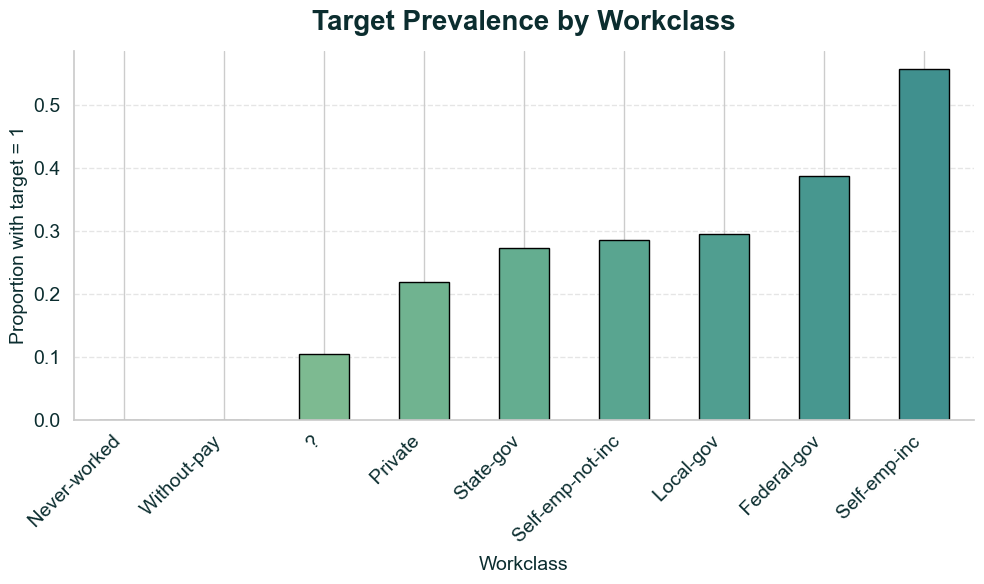

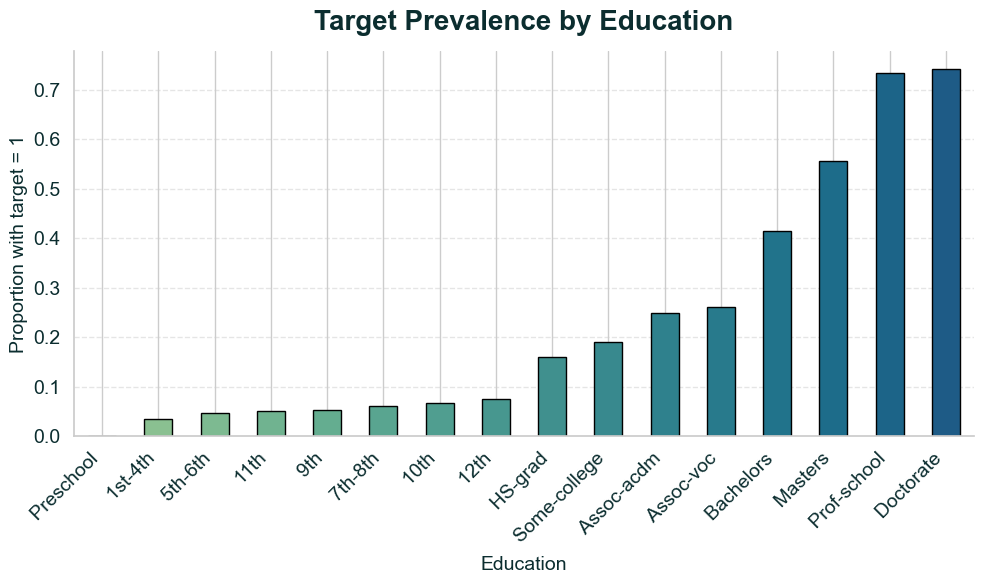

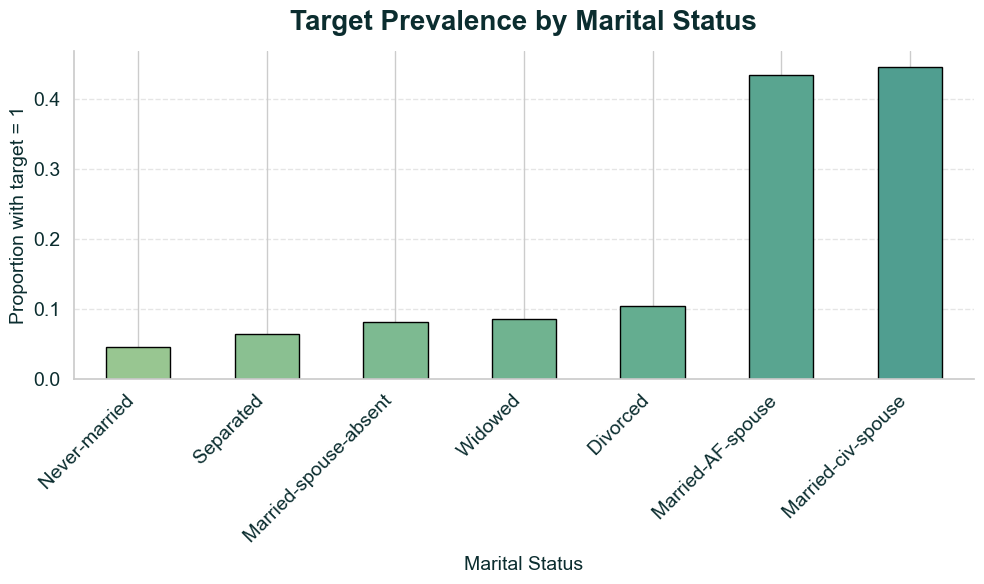

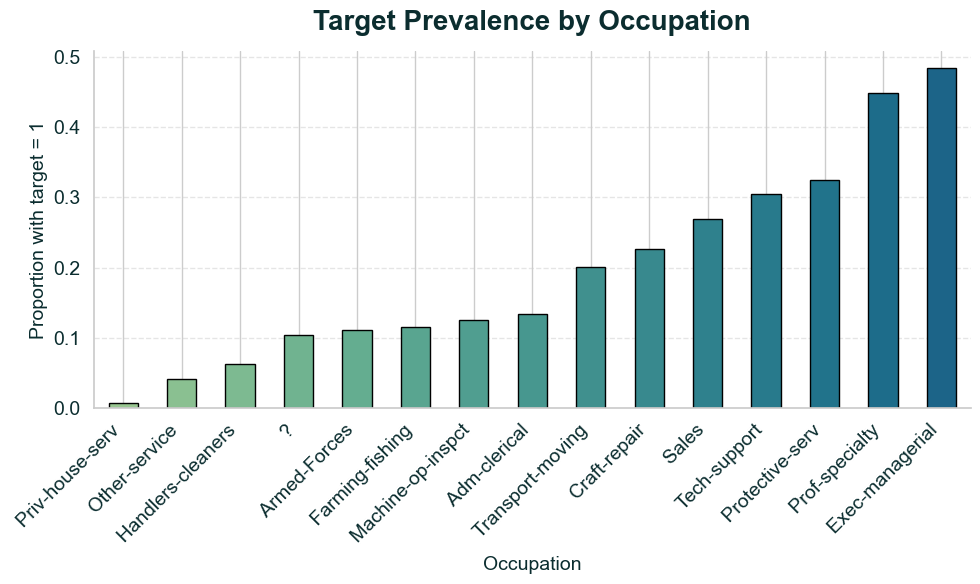

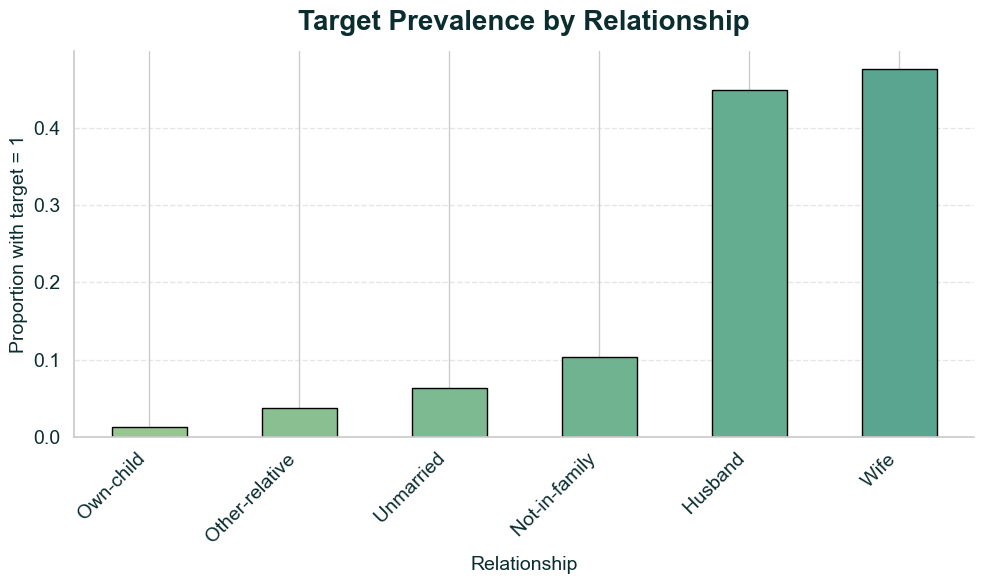

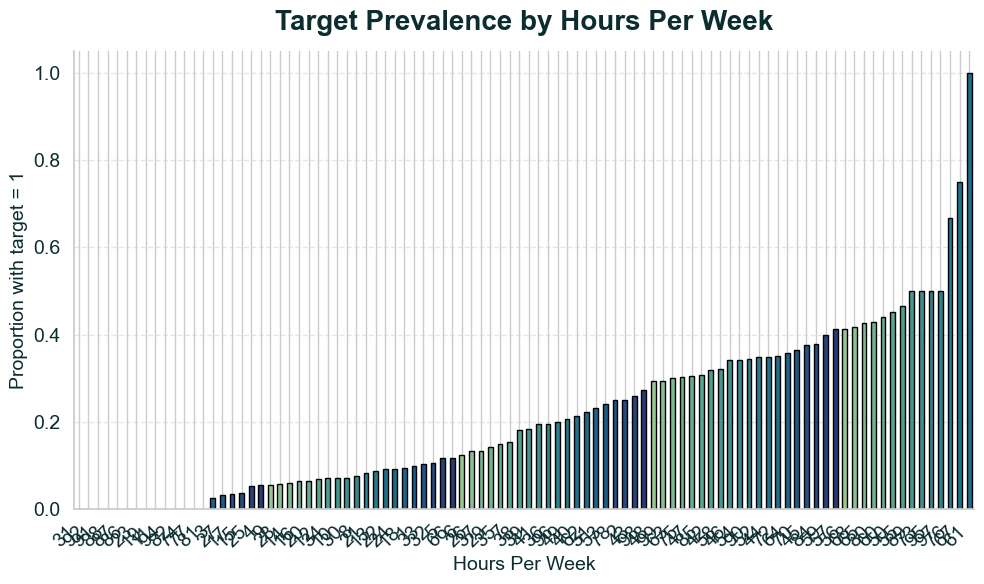

In [22]:
cats = ['workclass','education','marital-status','occupation','relationship','hours-per-week']
plot_prevalence_individual(train_df, cats)

**Now we apply these transformations to the data - remappings and binnings.**

In [8]:
BP = BasicPrep()

copy_df = train_df.copy()

eda_df = BP.transform(copy_df)

my_col = eda_df.pop('pred')

eda_df['pred'] = my_col

eda_df

,age,relationship,race,sex,workclass-cat,education-cat,marital-cat,occupation-cat,native_imm_cat,hours_bin,cap_flow_bin,pred
0,39,Not-in-family,White,Male,Government,Bachelors,Single/Unmarried,Service,Native,Underworked,Standard,0
1,50,Husband,White,Male,Unincorporated-Entrepreneur,Bachelors,Married,White-collar,Native,Part-Time,Standard,0
2,38,Not-in-family,White,Male,Private,HS-grad,Single/Unmarried,Manual,Native,Underworked,Standard,0
3,53,Husband,Black,Male,Private,HS-dropout,Married,Manual,Native,Underworked,Standard,0
4,28,Wife,Black,Female,Private,Bachelors,Married,White-collar,Immigrant,Underworked,Standard,0
...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Wife,White,Female,Private,Some-college,Married,White-collar,Native,Underworked,Standard,0
32557,40,Husband,White,Male,Private,HS-grad,Married,Blue-collar,Native,Underworked,Standard,1
32558,58,Unmarried,White,Female,Private,HS-grad,Single/Unmarried,Service,Native,Underworked,Standard,0
32559,22,Own-child,White,Male,Private,HS-grad,Single/Unmarried,Service,Native,Part-Time,Standard,0


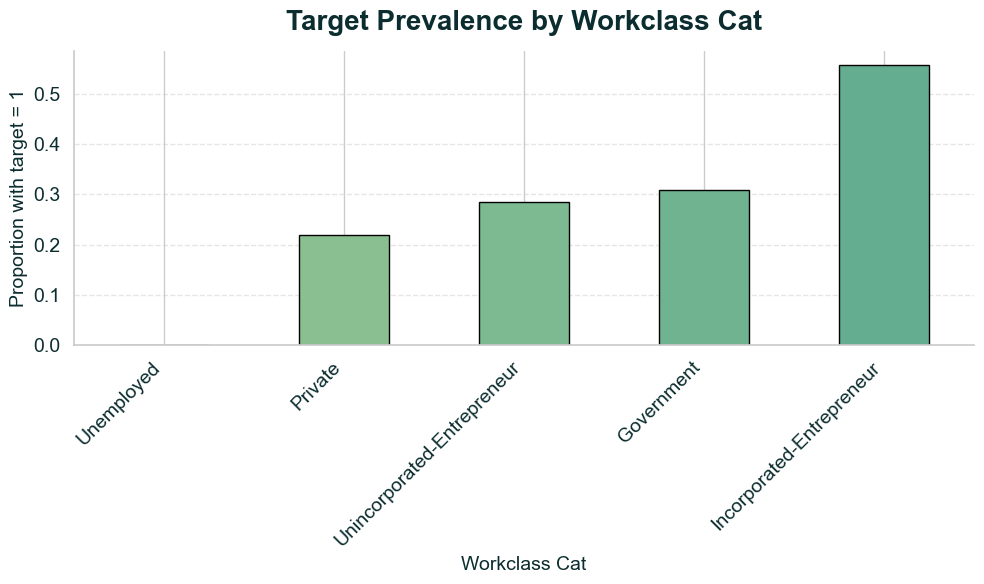

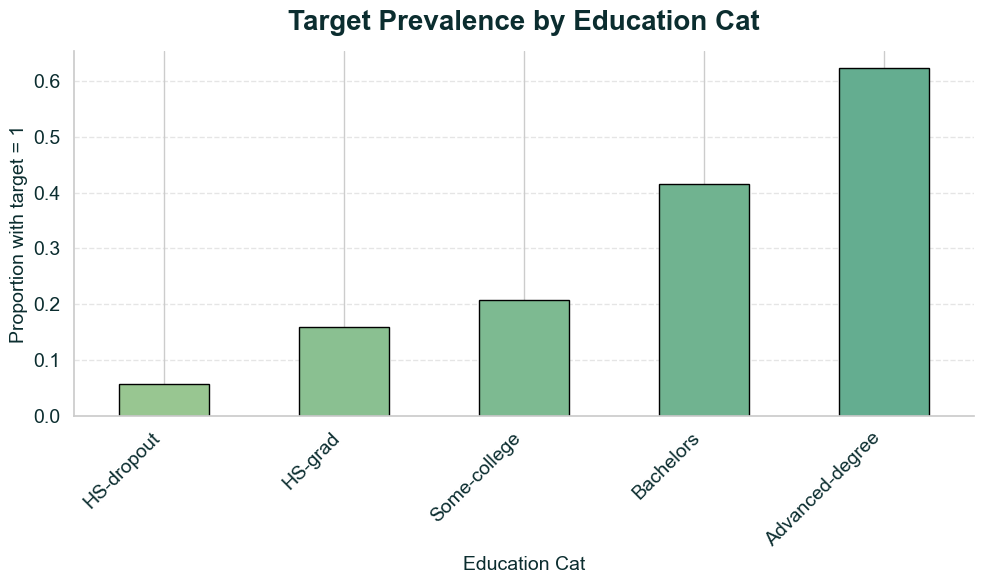

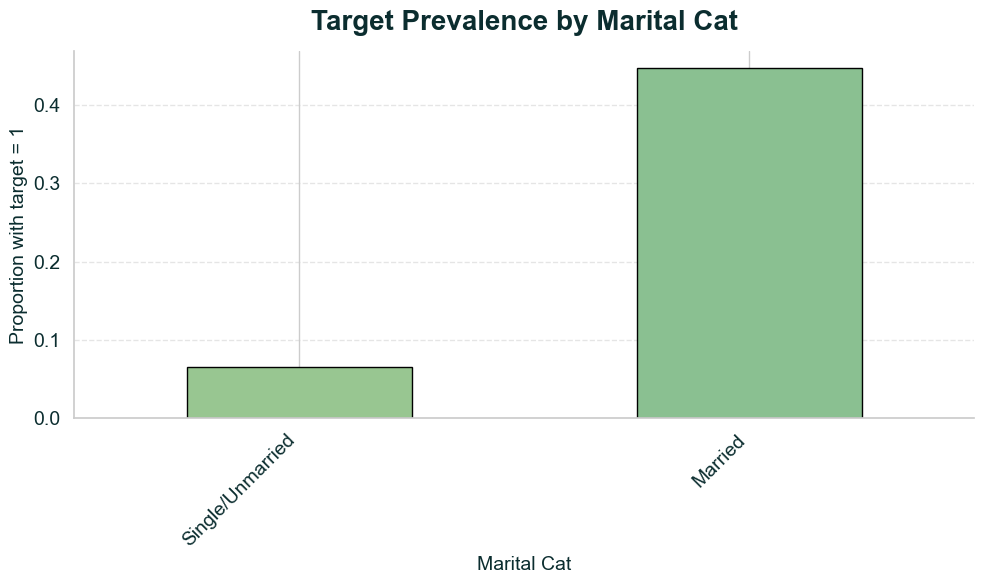

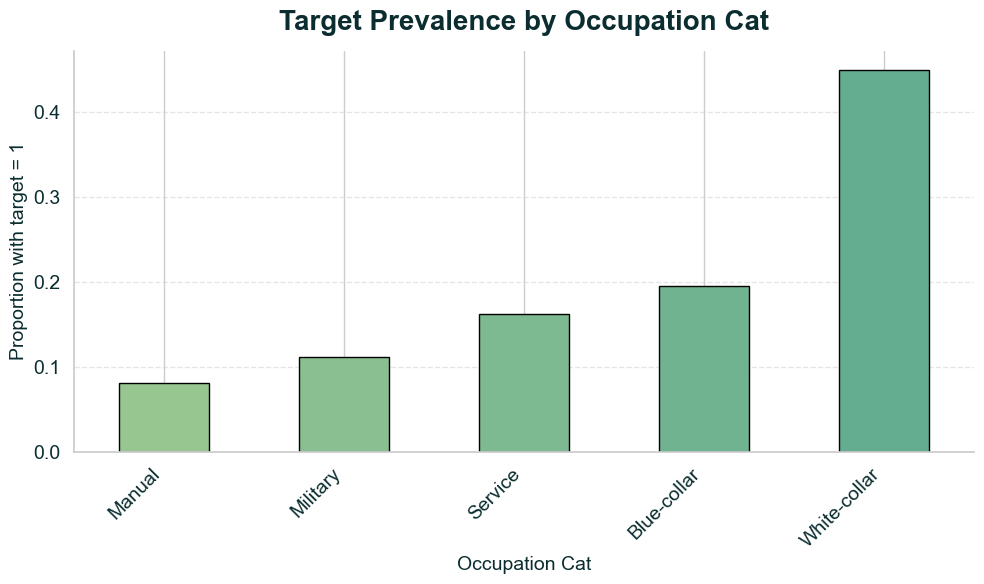

/var/folders/js/tqvb2m154v73xsdw47trh9xh0000gn/T/ipykernel_48082/2342941543.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prevalence = df.groupby(cat)[pred_col].mean().sort_values()


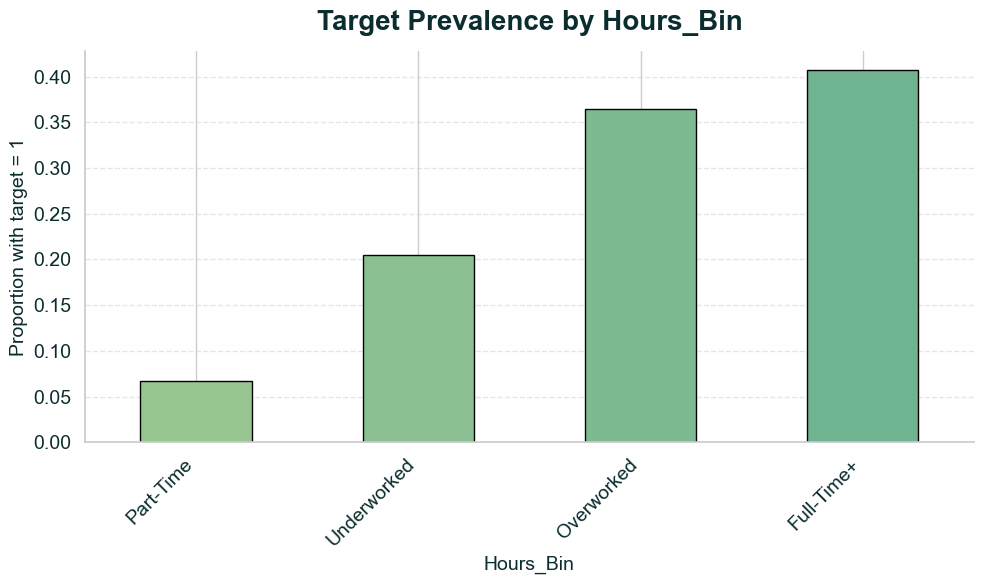

/var/folders/js/tqvb2m154v73xsdw47trh9xh0000gn/T/ipykernel_48082/2342941543.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prevalence = df.groupby(cat)[pred_col].mean().sort_values()


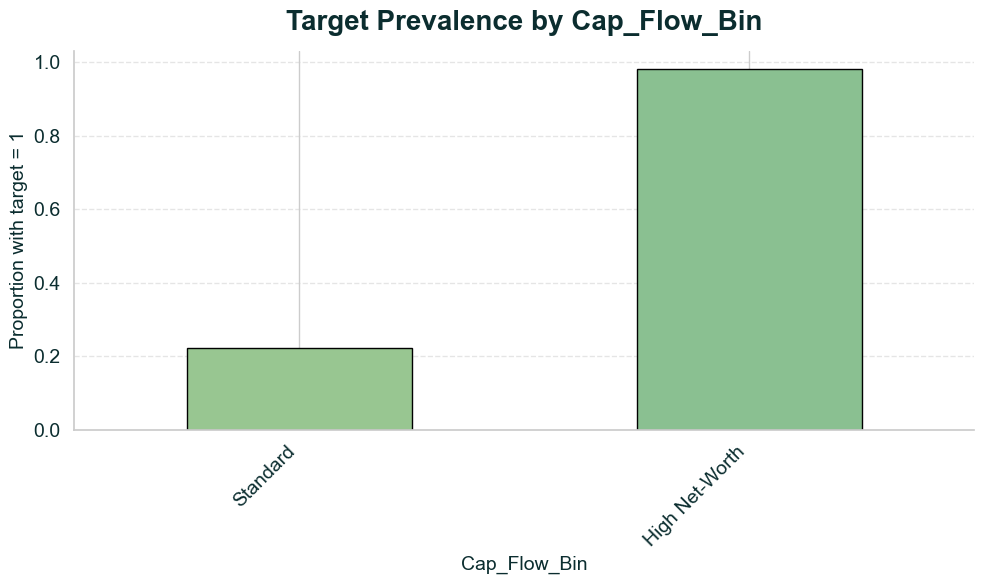

In [21]:
cats = ['workclass-cat','education-cat','marital-cat','occupation-cat','hours_bin','cap_flow_bin']
plot_prevalence_individual(eda_df, cats)

**These charts show fairly effective groupings were made - there is clear stratification between these groupings.**

In [36]:
def plot_cat_target_bars(df, cat_col, y_label = 'Category', target_col="pred"):
    """
    Diverging horizontal bar chart of correlation between each category of
    cat_col and the target variable.

    y-axis label  = y_label (e.g. "Education")
    y-tick labels = clean category names (e.g. "Bachelors", "HS-grad", ...)
    """
    sns.set_theme(style = 'white')
    # 1) One-hot encode the category
    dummies = pd.get_dummies(df[cat_col], prefix=cat_col, drop_first=False)

    # 2) Correlation with target
    corr_df = pd.concat([dummies, df[target_col]], axis=1)
    corr = corr_df.corr()[target_col].drop(target_col)

    # 3) Build Series of clean labels (indexed by dummy column name)
    clean_labels = pd.Series(
        corr.index.str.replace(f"{cat_col}_", "", regex=False),
        index=corr.index
    )

    # 4) Sort correlations (strongest positive first; change if you prefer abs)
    corr_sorted = corr.sort_values(ascending=False)
    clean_labels_sorted = clean_labels.loc[corr_sorted.index]

    # 5) Colors (green for +, blue-gray for −)
    colors = corr_sorted.apply(lambda x: "#A3C9A8" if x > 0 else "#87AFC7")

    # 6) Positions for bars
    y_pos = np.arange(len(corr_sorted))

    plt.figure(figsize=(9, 3))

    # Bars
    plt.barh(y_pos, corr_sorted.values, color=colors)

    # y-tick labels = clean category names
    plt.yticks(y_pos, clean_labels_sorted.values)

    # Zero line
    plt.axvline(0, color="black", linewidth=1)

    # Annotate values on bars


    plt.title("Correlation of Categories vs Target (+/- $50K)", fontsize=14)
    plt.xlabel("Correlation")
    plt.ylabel(y_label)
    plt.xlim(-0.5, 0.5)

    plt.tight_layout()
    plt.show()


**Here we provide another view of these categories, broken out by column.**

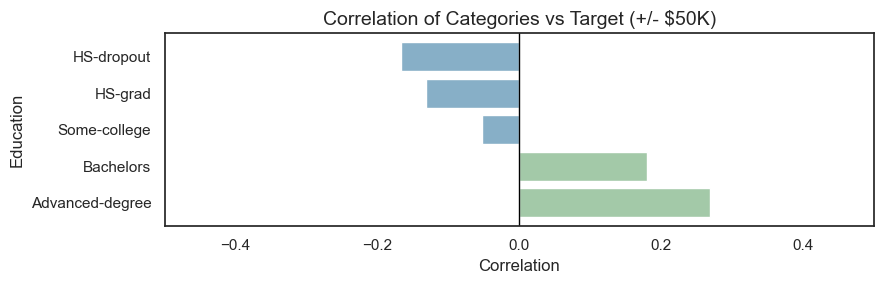

In [37]:
plot_cat_target_bars(eda_df, 'education-cat', 'Education')

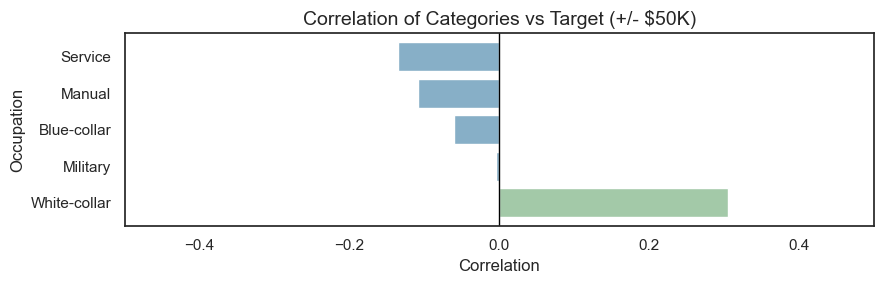

In [39]:
plot_cat_target_bars(eda_df, 'occupation-cat', 'Occupation')

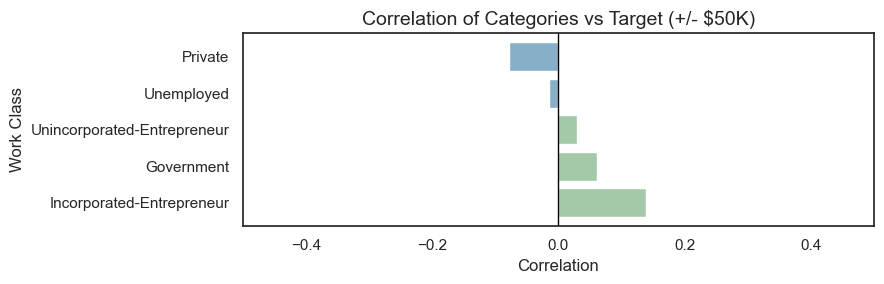

In [40]:
plot_cat_target_bars(eda_df, 'workclass-cat', 'Work Class')

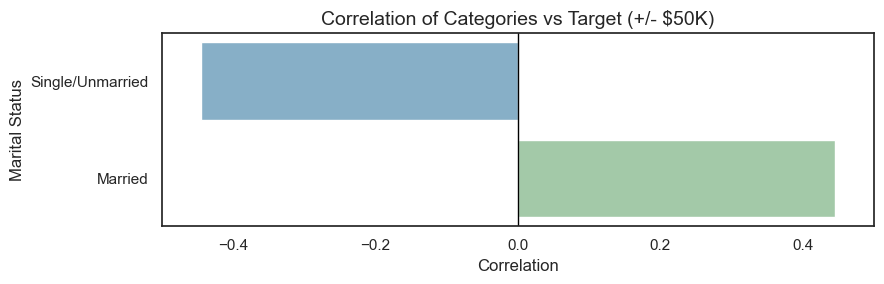

In [41]:
plot_cat_target_bars(eda_df, 'marital-cat', 'Marital Status')

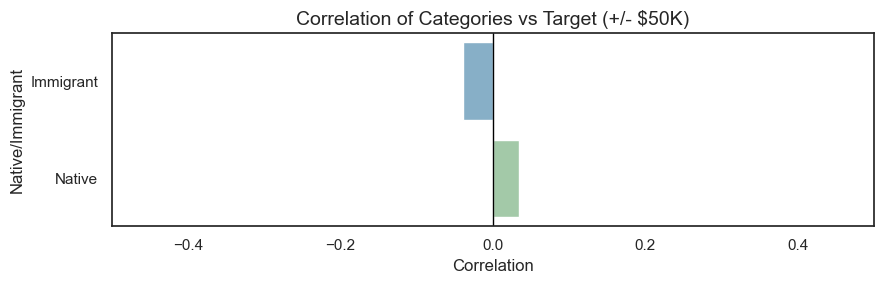

In [42]:
plot_cat_target_bars(eda_df, 'native_imm_cat', 'Native/Immigrant')

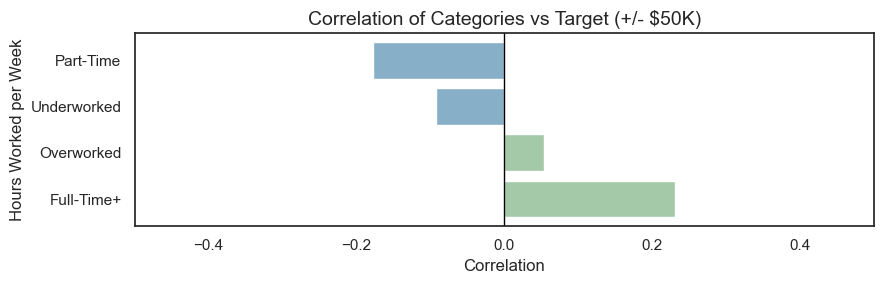

In [43]:
plot_cat_target_bars(eda_df, 'hours_bin', 'Hours Worked per Week')

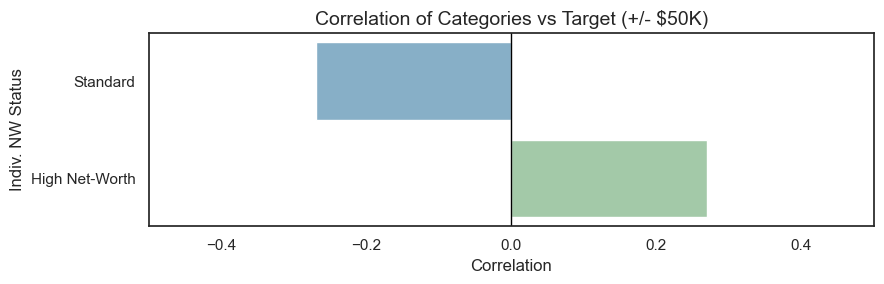

In [44]:
plot_cat_target_bars(eda_df, 'cap_flow_bin', 'Indiv. NW Status')

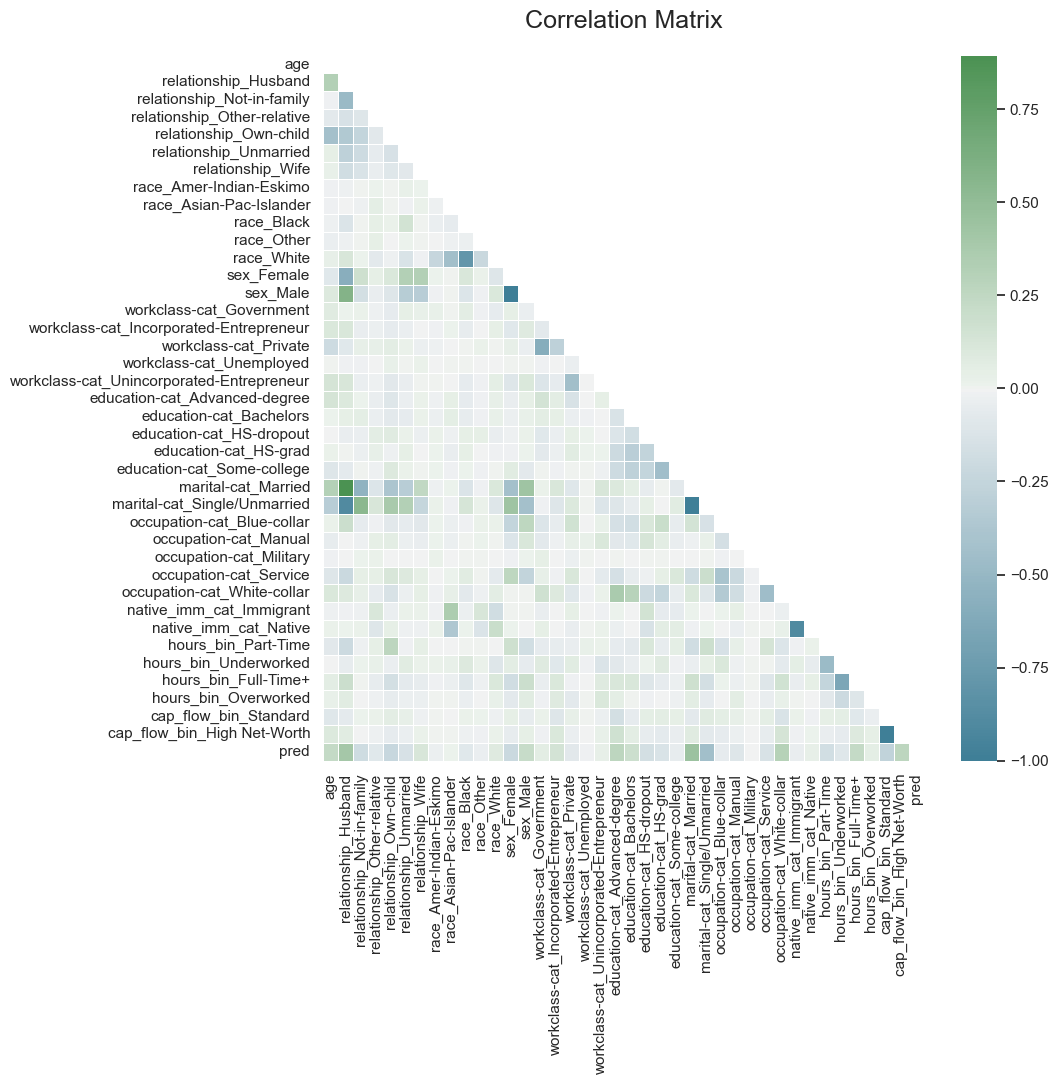

In [17]:
# --- 1. Encode categoricals, keep pred numeric ---
# (drop_first=False so every category appears)
encoded_df = pd.get_dummies(
    eda_df.drop(columns=["pred"]),
    drop_first=False
)

# add target back
encoded_df["pred"] = eda_df["pred"].values

# correlation matrix
corr_matrix = encoded_df.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(11, 11))  # put BEFORE heatmap
sns.set_theme(style = 'white')
ax = sns.heatmap(
    corr_matrix,
    mask=mask,
    cmap=sns.diverging_palette(225, 130, as_cmap=True),
    linewidths=0.5,
    center=0
)

ax.set_title("Correlation Matrix", fontsize=18, pad=20)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

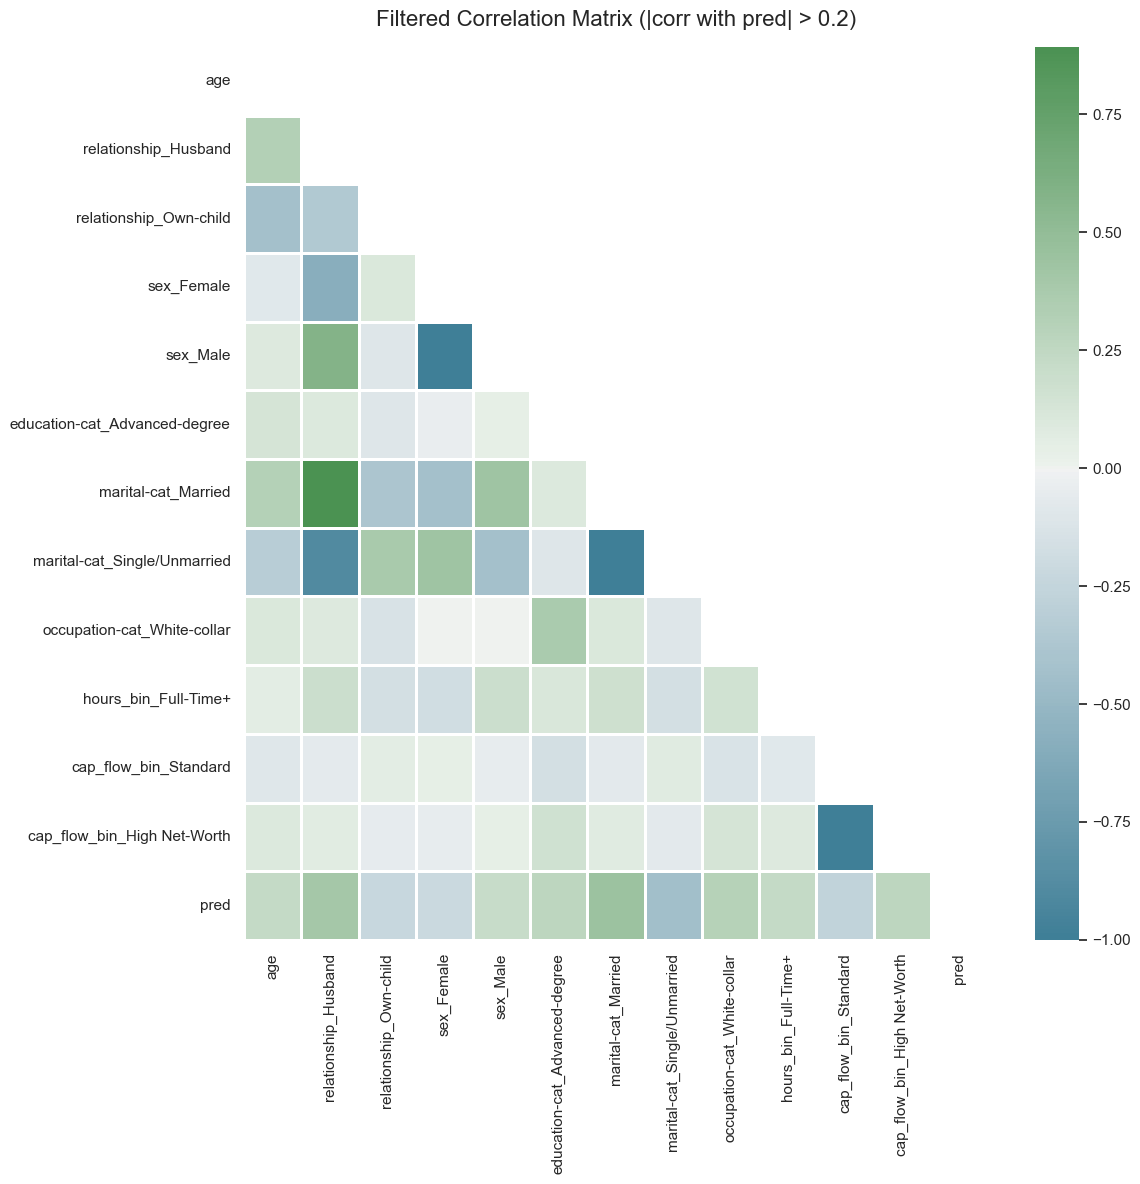

In [48]:
# absolute correlation with target
target_corr = corr_matrix["pred"].abs()

thresh = 0.2

# choose "important" columns
important_cols = target_corr[target_corr > thresh].index

# filter matrix to those cols only
filtered_corr = corr_matrix.loc[important_cols, important_cols]

mask_filt = np.triu(np.ones_like(filtered_corr, dtype=bool))

plt.figure(figsize=(12, 12))
ax = sns.heatmap(
    filtered_corr,
    mask=mask_filt,
    cmap=sns.diverging_palette(225, 130, as_cmap=True),
    linewidths=1,
    center=0,
    annot=False
)

ax.set_title(f"Filtered Correlation Matrix (|corr with pred| > {thresh})", fontsize=16, pad=15)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# Preparing, Running, and Tuning Models with GridSearchCV

In [ ]:
target_col = "pred"

X_train_raw = train_df.drop(columns=[target_col])
y_train = train_df[target_col]

X_test_raw  = test_df.drop(columns=[target_col])
y_test  = test_df[target_col]

X_train_drop_raw = train_df_drop.drop(columns=[target_col])

### Prepare Missing-Drop Dataset

In [ ]:
train_df_drop = train_df.copy()

train_df_drop = data_to_str(train_df_drop)
train_df_drop = replace_qmarks(train_df_drop)

### Prepare Dataset for Pipeline

## Testing: Correction for Data Imbalance

### RandomForest

In [ ]:
# Base RF settings (same for both)
rf_common_kwargs = dict(
    n_estimators=400,
    max_depth=None,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
)


# 1) RF + balanced_subsample
rf_balanced = RandomForestClassifier(
    class_weight="balanced_subsample",
    **rf_common_kwargs
)

rf_balanced_pipe = ImbPipeline(steps=[
    ("prep", BasicPrep()),
    ("preprocessor", preprocessor_rf),
    ("sampler", "passthrough"),
    ("clf", rf_balanced),
])

# 2) RF + no rebalancing
rf_plain = RandomForestClassifier(
    class_weight=None,   # <-- important: no balancing
    **rf_common_kwargs
)

rf_plain_pipe = ImbPipeline(steps=[
    ("prep", BasicPrep()),         # cleaning + remapping
    ("preprocessor", preprocessor_rf),
    ("sampler", "passthrough"),    # no oversampling
    ("clf", rf_plain),
])

In [ ]:
numeric_features = ["age"]

categorical_features = [
    "relationship", "race", "sex",
    "workclass-cat", "education-cat", "marital-cat",
    "occupation-cat", "native_imm_cat",
    "hours_bin", "cap_flow_bin"
]

# Numeric pipeline
numeric_transformer = skPipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("log", FunctionTransformer(np.log1p, feature_names_out="one-to-one")),
    ("scaler", MinMaxScaler())
])

# Categorical pipeline
categorical_transformer = skPipeline(steps=[
    ("imputer", SimpleImputer(
        strategy="most_frequent",   # or "constant" with fill_value="Unknown"
        fill_value="Unknown"
    )),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop"
)

In [ ]:
print("=== RF (Plain) ===")
rf_plain_pipe.fit(X_train_raw, y_train)
y_pred_plain = rf_plain_pipe.predict(X_test_raw)
print(classification_report(y_test, y_pred_plain))

print("\n=== RF + balanced_subsample ===")
rf_balanced_pipe.fit(X_train_raw, y_train)
y_pred_bal = rf_balanced_pipe.predict(X_test_raw)
print(classification_report(y_test, y_pred_bal))

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# ----- Bagged Decision Tree base setup -----
base_tree = DecisionTreeClassifier(
    random_state=42,
)

bb_tree = BalancedBaggingClassifier(
    estimator=base_tree,
    n_estimators=25,          # will be tuned
    sampling_strategy="auto", # balance classes in each bag
    replacement=True,
    random_state=42,
    n_jobs=-1,
)

dt_bag_pipe = ImbPipeline(steps=[
    ("prep", BasicPrep()),     # your cleaning + remapping
    ("preprocessor", preprocessor_rf),
    ("clf", bb_tree),
])

# ----- Hyperparameter grid for Bagged DT -----
dt_param_grid = {
    "clf__n_estimators": [200, 400],          # size of the bagging ensemble
    "clf__estimator__max_depth": [None, 10, 20],
    "clf__estimator__min_samples_leaf": [1, 2, 5],
}

dt_grid = GridSearchCV(
    estimator=dt_bag_pipe,
    param_grid=dt_param_grid,
    cv=5,
    scoring="f1_macro",  # or "accuracy", but f1_macro is nicer for imbalance
    n_jobs=-1,
    verbose=2,
)

# ----- Fit + evaluate -----
dt_grid.fit(X_train_raw, y_train)

print("Best params (Bagged DT):", dt_grid.best_params_)
print("Best CV score (Bagged DT):", dt_grid.best_score_)

y_pred_dt = dt_grid.predict(X_test_raw)
print("\n=== Test performance: Bagged DT ===")
print(classification_report(y_test, y_pred_dt))

In [ ]:
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

# Base tree for each bag
base_tree = DecisionTreeClassifier(
    max_depth=None,
    min_samples_leaf=2,
    random_state=42
)

bb_clf = BalancedBaggingClassifier(
    estimator=base_tree,           # base estimator in each bag
    n_estimators=100,               # number of bags (ensemble size)
    sampling_strategy="auto",      # balance minority/majority automatically
    replacement=True,              # bootstrap sampling
    random_state=42,
    n_jobs=-1
)

bb_pipe = ImbPipeline(steps=[
    ("prep", BasicPrep()),         # your cleaning + remapping
    ("preprocessor", preprocessor_rf),
    ("clf", bb_clf),
])

In [ ]:
models = {
    "RF_plain": rf_plain_pipe,
    "RF_balanced_subsample": rf_balanced_pipe,
    "BalancedBagging_DT": bb_pipe,
}

for name, pipe in models.items():
    print(f"\n=== {name} ===")
    pipe.fit(X_train_raw, y_train)
    y_pred = pipe.predict(X_test_raw)
    print(classification_report(y_test, y_pred))

### LogisticRegression

In [ ]:
from sklearn.linear_model import LogisticRegression

lr_base = LogisticRegression(
    max_iter=2000,
    n_jobs=-1,
    solver="lbfgs",
    penalty="l2",
    class_weight=None   # we’ll let bagging do the balancing
)

from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.pipeline import Pipeline as ImbPipeline

bb_logreg = BalancedBaggingClassifier(
    estimator=lr_base,
    n_estimators=25,          # you can bump to 50+ if runtime is OK
    sampling_strategy="auto", # balance the classes in each bag
    replacement=True,         # bootstrap sampling
    random_state=42,
    n_jobs=-1
)

bb_logreg_pipe = ImbPipeline(steps=[
    ("prep", BasicPrep()),     # your cleaner + remapper
    ("preprocessor", preprocessor),
    ("clf", bb_logreg),
])


In [ ]:
from sklearn.metrics import classification_report

print("=== Balanced Bagging + Logistic Regression ===")
bb_logreg_pipe.fit(X_train_raw, y_train)
y_pred_bb = bb_logreg_pipe.predict(X_test_raw)
print(classification_report(y_test, y_pred_bb))

In [ ]:
from sklearn.linear_model import LogisticRegression
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# ----- Bagged Logistic Regression base setup -----
lr_base = LogisticRegression(
    max_iter=2000,
    n_jobs=-1,
    solver="lbfgs",
    penalty="l2",
    # class_weight tuned in grid
)

bb_logreg = BalancedBaggingClassifier(
    estimator=lr_base,
    n_estimators=50,          # will be tuned
    sampling_strategy="auto", # class balancing per bag
    replacement=True,
    random_state=42,
    n_jobs=-1,
)

bb_logreg_pipe = ImbPipeline(steps=[
    ("prep", BasicPrep()),     # your cleaning + remapping
    ("preprocessor", preprocessor),  # log + MinMax + OHE
    ("clf", bb_logreg),
])

# ----- Hyperparameter grid for Bagged LogReg -----
lr_param_grid = {
    "clf__n_estimators": [200, 400],                 # number of bags
    "clf__estimator__C": [0.1, 1.0, 10.0],         # LR regularization
    "clf__estimator__class_weight": [None, "balanced"],
}

lr_grid = GridSearchCV(
    estimator=bb_logreg_pipe,
    param_grid=lr_param_grid,
    cv=5,
    scoring="f1_macro",  # or 'accuracy'
    n_jobs=-1,
    verbose=2,
)

# ----- Fit + evaluate -----
lr_grid.fit(X_train_raw, y_train)

print("Best params (Bagged LogReg):", lr_grid.best_params_)
print("Best CV score (Bagged LogReg):", lr_grid.best_score_)

y_pred_lr = lr_grid.predict(X_test_raw)
print("\n=== Test performance: Bagged LogReg ===")
print(classification_report(y_test, y_pred_lr))


## Testing Models & Hyperparameter Tuning

## Logistic Regression

In [ ]:
numeric_features = ["age"]

categorical_features = [
    "relationship", "race", "sex",
    "workclass-cat", "education-cat", "marital-cat",
    "occupation-cat", "native_imm_cat",
    "hours_bin", "cap_flow_bin"
]

# Numeric pipeline
numeric_transformer = skPipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("log", FunctionTransformer(np.log1p, feature_names_out="one-to-one")),
    ("scaler", MinMaxScaler())
])

# Categorical pipeline
categorical_transformer = skPipeline(steps=[
    ("imputer", SimpleImputer(
        strategy="most_frequent",   # or "constant" with fill_value="Unknown"
        fill_value="Unknown"
    )),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop"
)

In [ ]:
logreg_base = LogisticRegression(
    max_iter=1000,
    n_jobs=-1,
    solver="lbfgs",
    penalty="l2"
    #class_weight="balanced"
)

logreg_pipeline = ImbPipeline(steps=[
    ("prep", BasicPrep()),
    ("preprocessor", preprocessor),
    ("sampler", "passthrough"),  # will be set to ROS or passthrough in grid
    ("clf", logreg_base),
])

logreg_param_grid = {
    # --- categorical missing-data ---
    "preprocessor__cat__imputer__strategy": ["most_frequent", "constant"],
    # "constant" uses fill_value="Unknown" already set above

    # --- numeric normalization on age ---
    "preprocessor__num__log": [
        "passthrough",
        FunctionTransformer(np.log1p, feature_names_out="one-to-one"),
    ],
    "preprocessor__num__scaler": [
        "passthrough",
        MinMaxScaler(),
    ],

    # --- imbalance handling ---
    "sampler": [
        "passthrough",
        RandomOverSampler(random_state=42),
    ],

    # --- LogisticRegression hyperparams ---
    "clf__C": [0.1, 1.0, 10.0],
}

logreg_grid = GridSearchCV(
    estimator=logreg_pipeline,
    param_grid=logreg_param_grid,
    cv=5,
    scoring="accuracy",  # or 'f1_macro' or "accuracy
    n_jobs=-1,
    verbose=1
)

logreg_grid.fit(X_train_raw, y_train)

print("Best params (LogReg):", logreg_grid.best_params_)

print("Best CV accuracy (LogReg):", logreg_grid.best_score_)

print("Test accuracy (LogReg):", logreg_grid.score(X_test_raw, y_test))
print(classification_report(y_test, logreg_grid.predict(X_test_raw)))

y_pred_lr=logreg_grid.predict(X_test_raw)
conf= confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(8,6))
sns.heatmap(conf, annot=True, cmap= "crest", fmt="d", cbar=False)
plt.xlabel('predicted labels')
plt.ylabel ('true Labels')
plt.title('confusion matrix')
plt.show()


## RandomForestClassifier

In [ ]:
numeric_transformer_rf = skPipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    # no log, no scaler – RF is tree-based and scale-invariant
])

preprocessor_rf = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_rf, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder="drop"
)

In [ ]:
rf_base = RandomForestClassifier(
    random_state=42,
    n_jobs=-1
)

rf_pipeline = ImbPipeline(steps=[
    ("prep", BasicPrep()),
    ("preprocessor", preprocessor_rf),
    ("sampler", "passthrough"),
    ("clf", rf_base),
])

rf_param_grid = {
    # cat missing data
    "preprocessor__cat__imputer__strategy": ["most_frequent", "constant"],

    # imbalance handling
    "sampler": [
        "passthrough",
        RandomOverSampler(random_state=42),
    ],

    # RF hyperparams – trimmed
    "clf__n_estimators": [100, 200],       # 400 is overkill for a grid
    "clf__max_depth": [None, 20],          # drop the 10
    "clf__min_samples_leaf": [1, 2],       # drop the 5
}

rf_grid = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=rf_param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train_raw, y_train)

print("Best params (RF):", rf_grid.best_params_)
print("Best CV accuracy (RF):", rf_grid.best_score_)

print("Test accuracy (RF):", rf_grid.score(X_test_raw, y_test))
print(classification_report(y_test, rf_grid.predict(X_test_raw)))

# Dropped Data Analysis

In [ ]:
rf_param_grid = {
    # cat missing data
    #"preprocessor__cat__imputer__strategy": ["most_frequent", "constant"],

    # imbalance handling
    "sampler": [
        "passthrough",
        RandomOverSampler(random_state=42),
    ],

    # RF hyperparams – trimmed
    "clf__n_estimators": [200, 400],       # 400 is overkill for a grid
    "clf__max_depth": [20],          # drop the 10
    "clf__min_samples_leaf": [2],       # drop the 5
}

rf_grid = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=rf_param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train_drop_raw, y_train)

print("Best params (RF):", rf_grid.best_params_)
print("Best CV accuracy (RF):", rf_grid.best_score_)

print("Test accuracy (RF):", rf_grid.score(X_test_raw, y_test))
print(classification_report(y_test, rf_grid.predict(X_test_raw)))